In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pysal as ps
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
# from fancyimpute import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config IPCompleter.greedy=True

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
hdf = pd.read_csv('ratio_predicted.csv')
fent_all_years = pd.read_csv('all_fentanyl_by_county.txt', sep = '\t')
fent_13_17 = pd.read_csv('all_fent_by_county_13-17.txt', sep = '\t')
national_fent = pd.read_csv('national_fent.txt', sep = '\t')
national_all_opioids = pd.read_csv('grouped_by_year_not_county_all_opioids.txt', sep = '\t')
national_fent_cocaine = pd.read_csv('fent_and_cocaine.txt', sep = '\t')
fent_by_state = pd.read_csv('fent_state.txt', sep = '\t')

In [3]:
fent_all_years = fent_all_years.drop('Notes', axis = 'columns')
fent_all_years = fent_all_years.dropna()
fent_all_years.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_13_17 = fent_13_17.drop('Notes', axis = 'columns')
fent_13_17 = fent_13_17.dropna()
fent_13_17.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_fent = national_fent.drop('Notes', axis = 'columns')
national_fent = national_fent.dropna()
national_fent = national_fent.drop('Year Code', axis = 'columns')
national_fent.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_all_opioids = national_all_opioids.drop('Notes', axis = 'columns')
national_all_opioids = national_all_opioids.dropna()
national_all_opioids = national_all_opioids.drop('Year Code', axis = 'columns')
national_all_opioids.columns = ['year', 'deaths', 'population', 'crude_rate']

national_fent_cocaine = national_fent_cocaine.drop('Notes', axis = 'columns')
national_fent_cocaine = national_fent_cocaine.dropna()
national_fent_cocaine = national_fent_cocaine.drop('Year Code', axis = 'columns')
national_fent_cocaine.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_by_state = fent_by_state.drop(['Notes', 'Year Code'], axis = 'columns')
fent_by_state = fent_by_state.dropna()
fent_by_state.columns = ['state', 'state_code', 'year', 'deaths', 'population', 'crude_rate', 'aa_rate']

In [4]:
def convert_suppressed(entry):
    if entry == 'Suppressed':
        return 0
    elif entry == 'Missing':
        return 0
    elif entry == 'Unreliable':
        return 0
    else:
        return int(entry)

fent_all_years['deaths'] = fent_all_years['deaths'].apply(convert_suppressed)
fent_13_17['deaths'] = fent_13_17['deaths'].apply(convert_suppressed)
national_fent['deaths'] = national_fent['deaths'].apply(convert_suppressed)
national_all_opioids['deaths'] = national_all_opioids['deaths'].apply(convert_suppressed)
national_fent_cocaine['deaths'] = national_fent_cocaine['deaths'].apply(convert_suppressed)
fent_by_state['deaths'] = fent_by_state['deaths'].apply(convert_suppressed)

In [59]:
import plotly
import plotly.figure_factory as ff
plotly.tools.set_credentials_file(username='steve.riesenberg', api_key='XYKDTo19pHDM2oPU97oc')

# df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
# df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
# df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
# df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ['#edf8e9',
'#c7e9c0',
'#a1d99b',
'#74c476',
'#31a354',
'#006d2c']

endpts = [0.1, 10, 20, 30, 40]
fips = hdf.county_code.tolist()
values = hdf.ratio_pred_rate_lag17.tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'Overdose Rate Spatial Lag 2017',
    titlefont = {'size':28},
    legend_title = 'Rate per 100,000'
)

plotly.plotly.iplot(fig, filename = 'fent_2017_spatial_lag')
plotly.io.write_image(fig, 'images/spatial_lag2017.png')


/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Slow

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The draw time for this plot will be slow for clients without much RAM.


In [29]:
def convert_suppressed_rate(entry):
    if entry == 'Suppressed':
        return 0
    elif entry == 'Missing':
        return 0
    elif entry == 'Unreliable':
        return 0
    else:
        return float(entry)

all_overdose = pd.read_csv('All Overdose 2017.txt', sep = '\t')
all_overdose = all_overdose.drop('Notes', axis = 'columns')
all_overdose = all_overdose.dropna()
all_overdose.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate']
all_overdose['deaths'] = all_overdose.deaths.apply(convert_suppressed)
all_overdose['crude_rate'] = all_overdose.crude_rate.apply(convert_suppressed_rate)

In [36]:
all_overdose = all_overdose.merge(hdf[['county_code', 'ratio_predicted17']], on = 'county_code', how = 'right')

In [37]:
all_overdose['nonfent'] = all_overdose.deaths - all_overdose.ratio_predicted17

In [46]:
all_overdose['nonfent_rate'] = all_overdose['nonfent'] / all_overdose['population'].apply(int) * 100000

In [52]:
all_overdose[all_overdose['nonfent_rate'] > 0].nonfent_rate.quantile(0.8)

22.531895254695456

In [56]:
import plotly
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
plotly.tools.set_credentials_file(username='steve.riesenberg', api_key='XYKDTo19pHDM2oPU97oc')

# df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
# df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
# df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
# df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ['#edf8e9',
'#c7e9c0',
'#a1d99b',
'#74c476',
'#31a354',
'#006d2c']

endpts = [0.1, 10, 20, 30, 40]
fips = all_overdose.county_code.tolist()
values = all_overdose.nonfent_rate.tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'Overdose Deaths with No Fentanyl per 100,000 People, 2017',
    titlefont = {'size':28},
    legend_title = 'Rate per 100,000'
)

plotly.plotly.iplot(fig, filename = 'all_overdose_deaths_2017')
plotly.io.write_image(fig, 'images/all_overdose_deaths.png')


/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Slow

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The draw time for this plot will be slow for clients without much RAM.


In [66]:
scaler = StandardScaler()
hdf['ratio_pred_rate_scaled17'] = scaler.fit_transform(hdf['ratio_pred_rate17'].values.reshape(-1,1))
hdf['ratio_pred_rate_lag_scaled17'] = scaler.fit_transform(hdf['ratio_pred_rate_lag17'].values.reshape(-1,1))

In [69]:
w = ps.queen_from_shapefile('hdf.shp')
# row standardization 
w.transform = 'r'

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning:

SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)



SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)


/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning:

SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)



SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)


In [73]:
ps.Moran(hdf['ratio_pred_rate_scaled17'], w, two_tailed = False).p_sim

0.001

In [109]:
lisa = ps.Moran_Local(hdf['ratio_pred_rate_scaled17'].values, w)
hdf['sig_lisa'] = lisa.p_sim <= 0.005
hdf['quadrant'] = lisa.q
# same:0, cold:1, hot:2
quad_dict = {1:0, 2:1, 3:0, 4:2}
hdf['quadrant_color'] = hdf.quadrant.map(quad_dict)
hdf['quadrant_color'] = hdf.quadrant_color * hdf.sig_lisa


In [115]:
hdf[hdf.quadrant_color == 1]

,Unnamed: 0,county_code,geometry,county,state,deaths13,deaths14,deaths15,deaths16,deaths17,...,ratio_pred_rate_lag13,ratio_pred_rate_lag14,ratio_pred_rate_lag15,ratio_pred_rate_lag16,ratio_pred_rate_lag17,ratio_pred_rate_scaled17,ratio_pred_rate_lag_scaled17,sig_lisa,quadrant,quadrant_color
685,685,18047,"POLYGON ((-85.23972000000001 39.525132, -85.03...","Franklin County, IN",IN,NaN,NaN,NaN,NaN,NaN,...,1.310419,5.145667,10.994012,13.302335,21.876172,-0.411900,2.439083,True,2,1
694,694,18065,"POLYGON ((-85.327352 40.078303, -85.2123359999...","Henry County, IN",IN,NaN,NaN,NaN,NaN,NaN,...,1.808065,3.938719,4.618667,13.466425,27.208025,-0.411900,3.163572,True,2,1
742,742,18161,"POLYGON ((-84.81251899999999 39.727779, -84.81...","Union County, IN",IN,NaN,NaN,NaN,NaN,NaN,...,2.391418,7.511461,12.870046,22.631079,43.289348,-0.411900,5.348692,True,2,1
966,966,21017,"POLYGON ((-84.264825 38.325682, -84.193625 38....","Bourbon County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,2.399682,5.482628,10.618307,17.273650,22.142627,-0.411900,2.475288,True,2,1
969,969,21023,"POLYGON ((-84.051224 38.769315, -83.903347 38....","Bracken County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,3.718045,8.899029,19.375070,25.386361,32.086044,-0.411900,3.826394,True,2,1
1021,1021,21127,"POLYGON ((-82.791528 38.243528, -82.605312 38....","Lawrence County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,2.488651,3.956717,7.607137,14.661771,24.668433,-0.411900,2.818493,True,2,1
1025,1025,21135,"POLYGON ((-83.268022 38.61596, -83.03251400000...","Lewis County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,3.041467,5.860155,11.305151,16.430282,28.532262,-0.411900,3.343508,True,2,1
1037,1037,21159,"POLYGON ((-82.413619 37.854665, -82.3314649999...","Martin County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,2.945685,3.905171,7.210538,15.847817,24.762680,-0.411900,2.831300,True,2,1
1051,1051,21187,"POLYGON ((-84.81799599999999 38.709068, -84.78...","Owen County, KY",KY,NaN,NaN,NaN,NaN,NaN,...,3.309503,4.264611,8.486136,15.336876,22.416658,-0.411900,2.512524,True,2,1
1171,1171,24029,"POLYGON ((-76.000122 39.377255, -75.7646139999...","Kent County, MD",MD,NaN,NaN,NaN,NaN,NaN,...,2.050968,3.774697,6.145310,10.811515,23.784826,-0.411900,2.698429,True,2,1


In [118]:
import plotly
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
plotly.tools.set_credentials_file(username='steve.riesenberg', api_key='XYKDTo19pHDM2oPU97oc')

# df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
# df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
# df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
# df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ['#bdbdbd', '#67a9cf','#ef8a62']

endpts = [0.1, 1.9]
fips = hdf.county_code.tolist()
values = hdf.quadrant_color.tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'Hot and Cold Counties',
    titlefont = {'size':28},
    legend_title = 'Below or Above Expected Value given Neighboring Counties'
)

plotly.plotly.iplot(fig, filename = 'Hot anc Cold Counties 2017')
plotly.io.write_image(fig, 'images/hot_cold_2017.png')


/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/chart_studio/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/chart_studio/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k poi

The draw time for this plot will be slow for clients without much RAM.


In [121]:
hdf['scatter_color'] = hdf.quadrant_color.map({0:'#bdbdbd', 1:'#67a9cf',2:'#ef8a62'})

In [126]:
hdf.columns

Index(['Unnamed: 0', 'county_code', 'geometry', 'county', 'state', 'deaths13',
       'deaths14', 'deaths15', 'deaths16', 'deaths17', 'pop13', 'pop14',
       'pop15', 'pop16', 'pop17', 'total_deaths', 'percent_in_distress',
       'prate_13', 'prate_14', 'prate_15', 'prate_16', 'prate_17',
       'ratio_predicted13', 'ratio_predicted14', 'ratio_predicted15',
       'ratio_predicted16', 'ratio_predicted17', 'crude_rate13',
       'crude_rate14', 'crude_rate15', 'crude_rate16', 'crude_rate17',
       'crude_rate_lag13', 'crude_rate_lag14', 'crude_rate_lag15',
       'crude_rate_lag16', 'crude_rate_lag17', 'ratio_pred_rate13',
       'ratio_pred_rate14', 'ratio_pred_rate15', 'ratio_pred_rate16',
       'ratio_pred_rate17', 'ratio_pred_rate_lag13', 'ratio_pred_rate_lag14',
       'ratio_pred_rate_lag15', 'ratio_pred_rate_lag16',
       'ratio_pred_rate_lag17', 'ratio_pred_rate_scaled17',
       'ratio_pred_rate_lag_scaled17', 'sig_lisa', 'quadrant',
       'quadrant_color', 'scatter_color

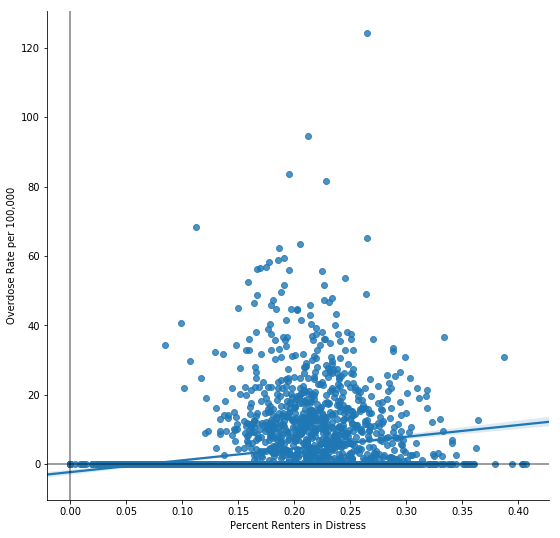

In [128]:
import seaborn as sns
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='percent_in_distress', y='ratio_pred_rate17', data=hdf)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set(xlabel='Percent Renters in Distress', ylabel='Overdose Rate per 100,000')
plt.title = 'Morans Autocorrelation Scatterplot'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Display
plt.show()

In [156]:
import plotly
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
plotly.tools.set_credentials_file(username='steve.riesenberg', api_key='XYKDTo19pHDM2oPU97oc')
states = ['WI', 'MO', 'IL', 'IN', 'MI', 'OH', 'KY', 'PA', 'WV', 'NC', 'VA', 'MD', 'DE', 'NJ', 'NY', 'CT', 'RI',
         'MA', 'VT', 'NH', 'ME', 'SC', 'GA', 'FL', 'TN']
# df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
# df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
# df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
# df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ['#edf8e9',
'#c7e9c0',
'#a1d99b',
'#74c476',
'#31a354',
'#006d2c']

endpts = [0.08, 0.17, 0.223, 0.257, 0.281]
fips = hdf[hdf.state.isin(states)].county_code.tolist()
values = hdf[hdf.state.isin(states)].percent_in_distress.tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = '2017 Percent in Distress',
    titlefont = {'size':20},
    legend_title = 'Percent'
)

plotly.plotly.iplot(fig, filename = '2017 Percent in Distress')
plotly.io.write_image(fig, 'images/east_distress.png')

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [164]:
import plotly
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
plotly.tools.set_credentials_file(username='steve.riesenberg', api_key='XYKDTo19pHDM2oPU97oc')
states = ['WI', 'MO', 'IL', 'IN', 'MI', 'OH', 'KY', 'PA', 'WV', 'NC', 'VA', 'MD', 'DE', 'NJ', 'NY', 'CT', 'RI',
         'MA', 'VT', 'NH', 'ME', 'SC', 'GA', 'FL', 'TN']
# df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
# df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
# df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
# df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ['#edf8e9',
'#c7e9c0',
'#a1d99b',
'#74c476',
'#31a354',
'#006d2c']

endpts = [3.8, 57.4, 88.1, 112.7, 130.6]
fips = hdf[hdf.state.isin(states)].county_code.tolist()
values = hdf[hdf.state.isin(states)].prate_17.tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = '2017 Prescription Rate',
    titlefont = {'size':20},
    legend_title = 'Rate per 100'
)

plotly.plotly.iplot(fig, filename = '2017 Prescription Rate')
plotly.io.write_image(fig, 'images/east_prate17.png')

/home/steve/anaconda3/envs/plotly/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [205]:
all_overdose

,county,county_code,deaths,population,crude_rate,ratio_predicted17,nonfent,nonfent_rate
0,"Autauga County, AL",1001.0,0,55504,0.0,0.0,0.0,0.000000
1,"Baldwin County, AL",1003.0,27,212628,12.7,8.0,19.0,8.935794
2,"Barbour County, AL",1005.0,0,25270,0.0,0.0,0.0,0.000000
3,"Bibb County, AL",1007.0,0,22668,0.0,0.0,0.0,0.000000
4,"Blount County, AL",1009.0,18,58013,0.0,5.0,13.0,22.408770
5,"Bullock County, AL",1011.0,0,10309,0.0,0.0,0.0,0.000000
6,"Butler County, AL",1013.0,0,19825,0.0,0.0,0.0,0.000000
7,"Calhoun County, AL",1015.0,31,114728,27.0,0.0,31.0,27.020431
8,"Chambers County, AL",1017.0,0,33713,0.0,0.0,0.0,0.000000
9,"Cherokee County, AL",1019.0,0,25857,0.0,0.0,0.0,0.000000


In [206]:
hdf = hdf.merge(all_overdose[['county_code','nonfent_rate']], on = 'county_code', how = 'left')

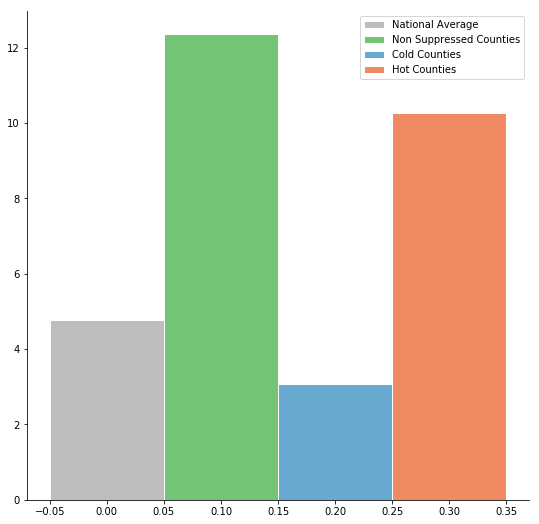

In [207]:
import matplotlib.pyplot as plt
# '#bdbdbd', '#67a9cf','#ef8a62'
f, ax = plt.subplots(1, figsize=(9, 9))
barWidth = 0.1
national_average = hdf.nonfent_rate.mean()
nonsuppressed = hdf[hdf.total_deaths > 0].nonfent_rate.mean()
hot = hdf[hdf.quadrant_color == 2].nonfent_rate.mean()
cold = hdf[hdf.quadrant_color == 1].nonfent_rate.mean()
plt.bar(x = 0,height = national_average, color= '#bdbdbd', width=barWidth, edgecolor='white', label='National Average')
plt.bar(x = 0.1, height = nonsuppressed, color = '#74c476', width=barWidth, edgecolor='white', label='Non Suppressed Counties')
plt.bar(x = 0.2, height = cold, color = '#67a9cf', width=barWidth, edgecolor='white', label='Cold Counties')
plt.bar(x = 0.3, height = hot, color = '#ef8a62', width=barWidth, edgecolor='white', label='Hot Counties')
plt.title = 'Average Population of County Groups'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
# Population, Overdose Rate, Overall Overdose Rate, Percent in Distress, Prescription Rate
national_average = [hdf.pop17, 30, 1, 8, 22]
nonsuppressed = [28, 6, 16, 5, 10]
hot = [29, 3, 24, 25, 17]
cold
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['A', 'B', 'C', 'D', 'E'])
 
# Create legend & Show graphic
plt.legend()
plt.show()